Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 9: Classification of the CIFAR-10 dataset using CNNs

J.B. Scoggins - Adrien Ehrhardt

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel color images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![](https://github.com/jbscoggi/teaching/blob/master/Polytechnique/CSE204/artwork/cifar_images.png?raw=1)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow, which you have already seen.

## Introduction to Keras

Keras is a high-level API to build and train deep learning models. It's used for fast prototyping, advanced research, and production, with three key advantages:

- __User friendly__: Keras has a simple, consistent interface optimized for common use cases. It provides clear and actionable feedback for user errors.
- __Modular and composable__: Keras models are made by connecting configurable building blocks together, with few restrictions.
- __Easy to extend__: Write custom building blocks to express new ideas for research. Create new layers, loss functions, and develop state-of-the-art models.

In Keras, models are built by assembling multiple layers.  Suppose we want to create a new multilayer perceptron model to categorize data with 128 features into 10 labeled categories. The Keras code could look like:

```python
# Create a sequential model
model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model
model.add(tf.keras.layers.Dense(64, activation='relu'), input_shape=[128])
# Add another
model.add(tf.keras.layers.Dense(32, activation='relu'))
# Add a softmax layer with 10 output units
model.add(tf.keras.layers.Dense(10, activation='softmax'))
```

The `input_shape` argument must be given for the first layer in the model, however all other layers will automatically determine the input shape based on the previous layer in the model.  Note that the code above is substantially simpler than the corresponding TensorFlow code.  This is particularly useful for building convolutional or other types of layers, as we will see.

Once built, a model's learning can be configured with the `compile()` function

```python
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.train.AdamOptimizer(0.001), 
    metrics=['accuracy'])
```

In this case, a cross-entropy loss function is used with the ADAM optimization algorithm.  The `metrics` argument allows the model to keep track of a number of [training metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) during training.

Once configured, training is performed using the `fit()` function.

```python
model.fit(data, labels, epochs=10, batch_size=32)
```

The function takes an array-like (could be numpy array) `data` argument and the corresponding `labels` values, and performs the optimization of the learnable parameters in the model.  See the documentation for the [fit()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#fit) function for more details.

Once trained, the model can be used to predict, using the `predict()` function. 

```python
prediction = model.predict(new_data)
```
  
## Tasks
Begin by importing the necessary modules.

In [3]:
import os
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow import keras
from keras.datasets.cifar import load_batch
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

2023-04-13 15:30:17.325530: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 15:30:17.327233: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 15:30:17.362806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 15:30:17.363540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 15:30:17.952159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Understand the dataset

Understanding your dataset is the first prerequisit to training any model. The CIFAR-10 dataset is provided directly from Keras. Implement the function `load_cifar_data` below to:

- Verify that the shape of the image and target arrays are what you expect.
- Create a list of `labels` corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows:
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck
- Normalize the image data from [0,255] to be [0,1]. Normalizing improves model training (to test this, you can comment out the normalization later);
- Lastly, convert the target arrays to one-hot encodings. *Hint*: checkout the [`tf.keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

In [4]:
def load_cifar():
    path = "/home/jovyan/shareddata/CSE204/cifar-10-batches-py/"
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.empty((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        (
            x_train[(i - 1) * 10000 : i * 10000, :, :, :],
            y_train[(i - 1) * 10000 : i * 10000],
        ) = load_batch(fpath)

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)

In [5]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training: 
        - one-hot encoding;
        - normalization;
        - labels (list of strings associated to the one-hot encoding of `y`).
    """
    # Download / Load the datasets
    # If not on JupyterCloud, comment the following line BUT uncomment it again
    # when submitting
    #(x_train, y_train), (x_test, y_test) = load_cifar()
    # If not on JupyterCloud, uncomment the following line BUT comment it again
    # when submitting
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # One-hot encoding
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    # Normalization
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255
    x_test /= 255

    # Labels
    labels = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]


    return x_train, y_train, x_test, y_test, labels

In [6]:
x_train, y_train, x_test, y_test, labels = load_cifar_data()
assert x_train.shape == (50000, 32, 32, 3)
assert 0 <= x_train[0][0][0][0] <= 1

Implement the function `show_first_n_images_in_categories` below to visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`. Can you recreate the figure at the top of today's lab?

*Hint*: the it was created using the first 8 images belonging to each category in the training data.

In [10]:
# Visualize the dataset
def show_first_n_images_in_categories(n: int, images: np.array, categories: np.array,
                                      labels: np.array, file_name: str = None):
    """Plots the first n images in each category from the image data.
    
    :param int n: number of images per category to plot
    :param numpy.array images: images as numerical data (x_*)
    :param numpy.array categories: the categories of each image in `images`
    :param numpy.array labels: the labels of categories 0 .. 9    
    :param str file_name: print figure to file (optional)
    """

    f, axes = plt.subplots(n, 10, figsize=(11, 8))

    for row in range(10):
        axes[0, row].set_title(labels[row])

    for row in range(10):
        for column in range(n):
            categorical_images = images[np.where(categories[:, row] == 1)[0]]
            axes[column, row].imshow(categorical_images[column])
            axes[column, row].axis('off')

    f.tight_layout()
    plt.show()
    

    




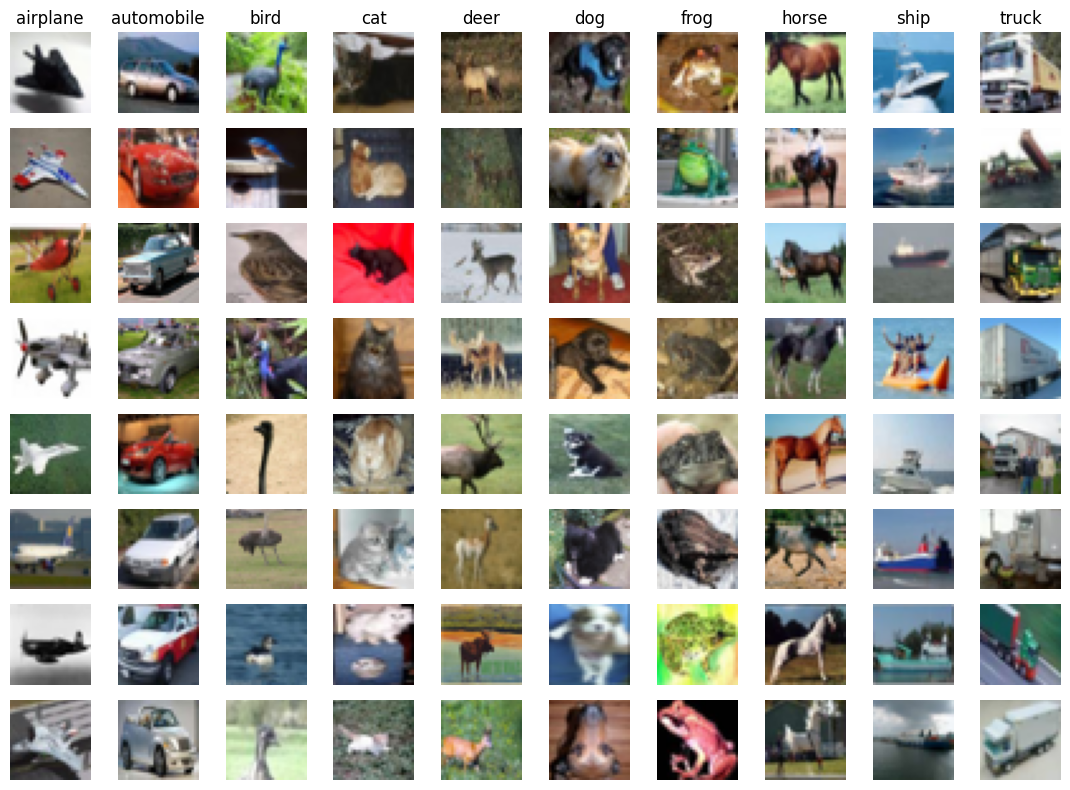

In [11]:
show_first_n_images_in_categories(8, x_train, y_train, labels)

### First naive model

In order to better understand the importance of CNNs, and in general whenever you are confronted with a Machine Learning problem, it is instructive to draft a **baseline**, and improve from there. Let's first see how well a naive dense network does, similar to the ones we've done in the previous lab.

- Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes.  Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D. How is the resulting vector ordered with respect to its original 3D structure?
- Compile the model with a `categorical_crossentropy` loss, using the [SGD optimizer](https://keras.io/api/optimizers/sgd/), including the `accuracy` metric.

*Note*: this is similar to [lab_session_07](https://adimajo.github.io/CSE204-2022-admin/lab_session_07.html).

In [20]:
def dense_model(input_shape, num_classes):
    """
    Returns a compiled keras Sequential model
    
    :param tuple input_shape: shape of ONE example as passed to the first layer
    :param int num_classes: number of output classes as passed to the last layer
    """

    model =  keras.Sequential()

    # We add batch normalization after every hidden layer
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='linear'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
    return model

In [21]:
model = dense_model(x_train.shape[1:], 10)

In [22]:
assert len(model.layers) >= 6
assert 'flatten' in model.layers[0].name.lower()
assert model.optimizer.name == 'SGD'

- Compute by hand the total number of trainable parameters (weights and biases) in the model (you can add an image in a new cell using Edit > Insert New Image; provide some detail...).

The number of parameters in the model can be calculated by adding up the products of the number of nodes in each layer and the number of nodes in the next layer plus the number of nodes in the next layer. The input image size is 32x32x3, the output has 10 classes, and there are four in-between layers with 2048, 1024, 512, and 256 nodes respectively. The total number of parameters in the model is 9,050,378.

- Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 2048)              6293504   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 9,050,378
Trainable params: 9,050,378
Non-

#### SGD algorithm (recall from [lab_session_06](https://adimajo.github.io/CSE204-2022-admin/lab_session_06.html))

Until now, we used (the "classical" or "batch") gradient descent, i.e. we summed the gradient of the loss w.r.t. each point in the dataset and then performed an update step, e.g.

$$\theta^{(t + 1)} = \theta^{(t)} - \eta \sum_{i=1}^n \nabla_{\theta^{(t)}}\ell_i.$$

Whenever $n$ is very large, this can become a problem. Alternatively, one could do:

$$\theta^{(t + 1)} = \theta^{(t)} - \eta \nabla_{\theta^{(t)}} \ell_i,$$

where $i$ is sampled randomly without replacement from $\{1, \dots, n\}$ and $\theta$ denotes either the weight $W^\ell$ or the bias $b^\ell$. Now $\theta^{(t)}$ changes "more often" so this can yield instabilities... such that "mini-batch(es)" might be needed: instead of using all the training data, or a single data point, we split the data into smaller subsets (e.g. 32 samples).

- Train the model:
  - Start with a small batch size of 32 samples and train the model for 10 epochs;
  - Use early stopping on the validation accuracy with a patience of 2.

*[Early stopping](https://keras.io/api/callbacks/early_stopping/):* stop before reaching the specified number of epochs if given criteria are met, e.g. if a level of improvement during the last epoch(s) has not been reached.

*Patience:* number of epochs where the given criteria have not been matched, but we "pay to view".

*[Keras callbacks](https://keras.io/api/callbacks/)*: functions evaluated at the end of each epoch, e.g. an early stopping rule, or some monitoring / saving function, ...

In [23]:
#earlystopping import 
from keras.callbacks import EarlyStopping

def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10, file_name: str = None):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size: 
    :param int epochs: 

    """


    model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_accuracy', patience=2)])
    return model

In [24]:
# Uncomment: Computationally heavy
train_model(model, x_train, y_train, x_test, y_test, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 40s 25ms/step - loss: 3.5490 - accuracy: 0.0955 - val_loss: 2.7669 - val_accuracy: 0.0902
Epoch 2/10
1563/1563 [==============================] - 40s 26ms/step - loss: 2.6809 - accuracy: 0.0741 - val_loss: 2.6931 - val_accuracy: 0.0838
Epoch 3/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.5333 - accuracy: 0.0864 - val_loss: 2.4201 - val_accuracy: 0.0790


- How does the model perform? Is it any better than a random guess? 
- Try changing the batch size to see if there is any improvement.
- Try adding batch normalization after each hidden layer.  Any better?

Discuss in the cell(s) below.

ANSWER:
The model performs worse than a random guess. The accuracy is 10% and the validation accuracy is 10%. The batch size of 32 samples did not improve the model. Adding batch normalization after each hidden layer did not improve the model.

Increasing/decreasing the batch size does not show improvement

Adding batch normalization after every hidden layer did not show an improvement either





### Convolutional Networks

Convolutional neural networks (see this week's slides - **tomorrow**) allow us to do drastically better on this dataset (and many image classification problems in general). In this task, you will build your first convolutional network and see how it performs.

Anticipating on tomorrow's lecture, the idea of Convolutional Networks is to rely on "filters" which can be interpreted as (spatially) **shared** weights. In the following example, we have an 8x8 grayscale image to which we apply a 3x3 filter. A filter is similar to the weight matrix $W^\ell$ that we have seen up to now for fully connected / dense neural networks, except that its parameters (*i.e.* each entry of the weight matrix) is the same for each input; it is "slided" vertically and horizontally:

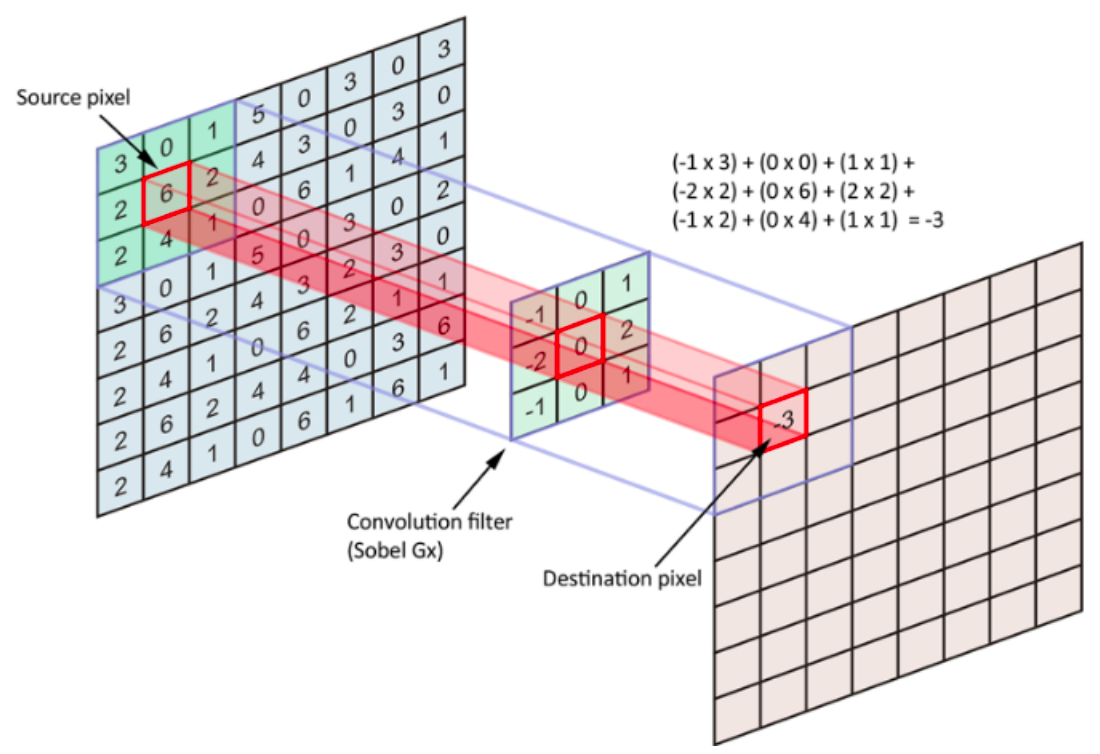

In the example above, the output has same size as the input, such that we used:

* "same" padding
    
Padding means adding 0s to the edges of the input such that the result of applying the filter has the desired size. In this example, "same" padding is equivalent to using a padding that makes the output the same shape as the input. To do so a row and a column of 0s is implicitly added at the beginning and at the end of the input.

* a stride of 1

The stride denotes by how much indices we shift the filter horizontally and vertically at each step. A stride of 2 is given as an example below:

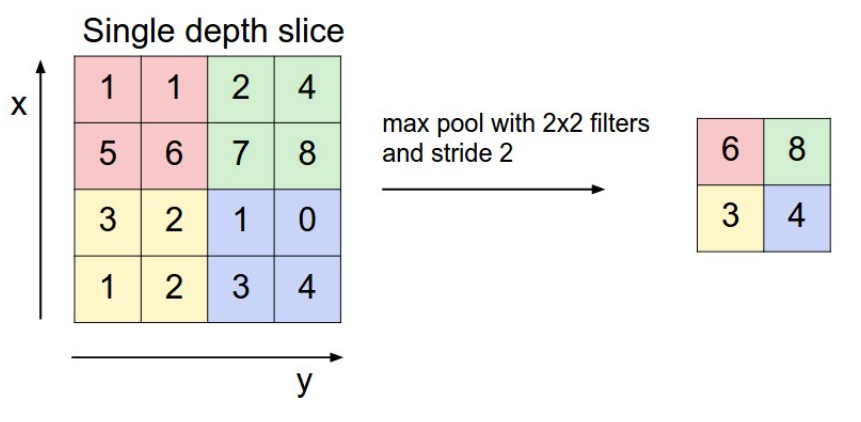

You may have noticed that in the example above, we don't apply a filter to the input but rather we take the maximum in each "area". This is called a maxpool layer and it is used to progressively reduce the size of the input in hidden layers. Stacking convolutional layers and maxpool layers forms the basis of many image classification competition winners in the last decade, such as LeNet-5 (interpret "Subsampling" as maxpooling on this figure):

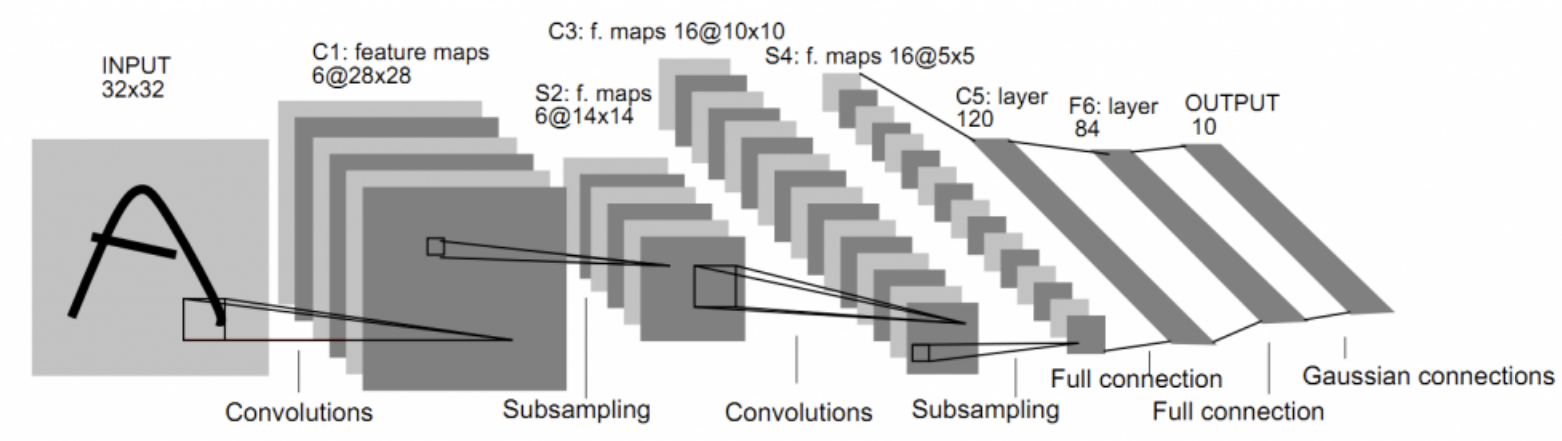

Note that at some point, we still flatten the input and use a fully connected layer so as to be able to output *e.g.* predicted labels (more on this below).

- Create a new model with the following layers
  - 3x3 [2D convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) with zero padding (same), 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes
- Compile the network with same optimizer and metrics as the dense network. 

In [25]:

def cnn_model(input_shape: tuple, num_classes: int):
    """
    Returns a compiled keras Conv2D model
    
    :param tuple input_shape: shape of ONE example as passed to the first layer
    :param int num_classes: number of output classes as passed to the last layer
    """
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])   
    return model


In [26]:
model = cnn_model(x_train.shape[1:], 10)
assert len(model.layers) >= 8

- Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network? Why? (Give some details; use the markdown cell below OR add a new cell add an image using Edit > Insert Image).

The number of trainable parameters in this network can be calculated as follows:

- The first Conv2D layer has 32 filters, each with a size of 3x3 and a depth of input_shape[2]. So it has (33input_shape[2]+1)*32 = 896 trainable parameters.
- The second Conv2D layer has 32 filters, each with a size of 3x3 and a depth of 32. So it has (3332+1)*32 = 9248 trainable parameters.
- The third Conv2D layer has 64 filters, each with a size of 3x3 and a depth of 32. So it has (3332+1)*64 = 18496 trainable parameters.
- The fourth Conv2D layer has 64 filters, each with a size of 3x3 and a depth of 64. So it has (3364+1)*64 = 36928 trainable parameters.
- The Dense layer has 512 nodes connected to the flattened output of the previous layer. So it has (6444+1)*512 = 524800 trainable parameters.
- The output Dense layer has num_classes nodes connected to the previous layer. So it has (512+1)*num_classes = (512+1)*10 = 5130 trainable parameters.
Therefore, the total number of trainable parameters in this network is:

896 + 9248 + 18496 + 36928 + 524800 + 5130 = 890410

There are more trainable parameters in this network than in a simple dense network because convolutional layers have more weights per filter than fully connected layers, and this network has four convolutional layers plus a dense layer with many nodes. Also, the use of activation functions requires additional trainable parameters for each layer. However, convolutional layers are able to learn spatial features from the input data and reduce the number of parameters needed to represent the data compared to fully connected layers.

Confirm with `summary()`.

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                      

- Use the same training procedure as before for 10 epochs and batch size of 32.
- How does the validation accuracy change with each epoch?
- Increase the batch size to 64 and retrain.  Better or worse?  Try 128 as well.  How does increasing the batch size improve the training?
- Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomena called?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve over-fitting?
- Play with batch normalization.  For example, add batch normalization layers after each dropout layer.  Do you notice a faster increase in the model improvement? Why?

Discuss in the cell(s) below.

- The validation accuracy typically increases and then plateaus or begins to decrease with each epoch as the model starts to overfit to the training data.
- Increasing the batch size can improve training by reducing the variance in the gradient estimates, leading to more stable updates and potentially faster convergence. However, increasing the batch size too much may also lead to slower convergence or worse generalization.
- The phenomenon of decreasing validation accuracy while training accuracy continues to increase is called overfitting. This occurs when the model starts to memorize the training data rather than learning more general patterns that can be applied to new data.

In [28]:
# Uncomment: computationally heavy
train_model(model, x_train, y_train, x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.0037 - accuracy: 0.2691 - val_loss: 1.7895 - val_accuracy: 0.3660
Epoch 2/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.6258 - accuracy: 0.4142 - val_loss: 1.5585 - val_accuracy: 0.4332
Epoch 3/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4263 - accuracy: 0.4865 - val_loss: 1.3640 - val_accuracy: 0.5139
Epoch 4/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3009 - accuracy: 0.5377 - val_loss: 1.2454 - val_accuracy: 0.5504
Epoch 5/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2047 - accuracy: 0.5712 - val_loss: 1.2043 - val_accuracy: 0.5702
Epoch 6/10
1563/1563 [==============================] - 27s 18ms/step - loss: 1.1194 - accuracy: 0.6053 - val_loss: 1.1530 - val_accuracy: 0.5875
Epoch 7/10
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0430 - accuracy: 0.6341 - val_loss: 1.1157 -

YOUR ANSWER HERE

### Make some predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of predictions:

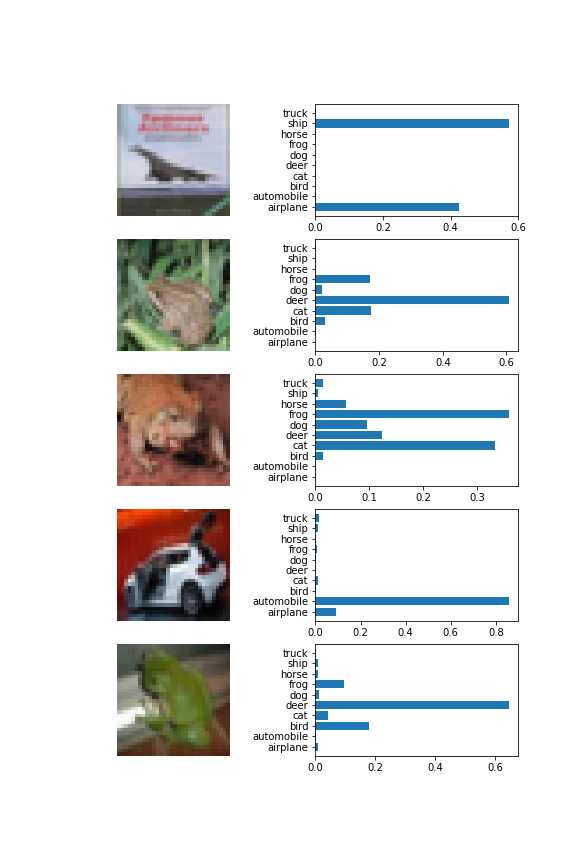

- Use `predict` on your trained model to test its prediction on a few example images.  You can use images taken from the test dataset, as these were not used to train your model. *Hint*: it can be convenient to use the `save` and `load_model` functions from Keras if you plan on working back and forth on the lab, i.e. you can save the model after training it, and then decide to load from from the file instead of building a new one on successive runs.
- Using `imshow`, subplots and `barh` from `matplotlib.pyplot`, try to recreate the image above for a few example images.

In [29]:
def predict(model, x: np.array, labels: list, file_name: str = None) -> np.array:
    """
    Plots the figures for which we want to predict the class alongside
    the predicted probabilities of each class.

    :param model: Keras model
    :param numpy.array x: a few test points to predict
    :param list labels: the list of labels associated with classes 0, ..., 9
    :param str file_name: (optional) filename to save the plot
    :return: the class prediction
    """
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = [labels[i] for i in y_pred]
    return y_pred

1/1 [==============================] - 0s 68ms/step


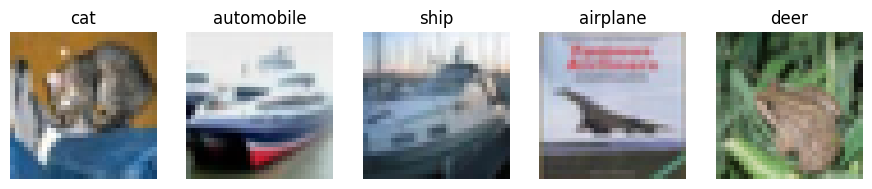

In [30]:
def plot_prediction(model, x: np.array, labels: list, file_name: str = None):
    """
    Plots the figures for which we want to predict the class alongside
    the predicted probabilities of each class.

    :param model: Keras model
    :param numpy.array x: a few test points to predict
    :param list labels: the list of labels associated with classes 0, ..., 9
    :param str file_name: (optional) filename to save the plot
    """
    y_pred = predict(model, x, labels)
    f, axes = plt.subplots(1, len(x), figsize=(11, 8))
    for i in range(len(x)):
        axes[i].imshow(x[i])
        axes[i].set_title(y_pred[i])
        axes[i].axis('off')
    plt.show()

plot_prediction(model, x_test[:5], labels)

- Create a _confusion matrix_. A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents for each true (actual) class i the predicted class j.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|                    | _predicted_ male | _predicted_ female |
|--------------------|------------------|--------------------|
| _actual_ male      | 3                | 2                  |
| _actual_ female    | 1                | 4                  |

The confusion matrix gives us more information than a simple accuracy measurement.  In this case, we see that the class female has a higher accuracy over male. Create the confusion matrix **as a Pandas DataFrame** on the CIFAR-10 dataset using the test data, with **"actual {label}"** as rows and **"predicted {label}"** as columns.  What does it tell you about the relationships between each class? Comment in the cell(s) below.

In [41]:
def confusion_matrix(model, x_test: np.array, y_test: np.array, labels: list) -> pd.DataFrame:
    """
    Predict on x_test using model
    Use sklearn.metrics.confusion_matrix to get the matrix
    Prettify the result

    :param model: keras model
    :param numpy.array x: a few test points to predict
    :param numpy.array x: true values associated with x_test
    :param list labels: list of names of labels
    """
    y_pred = predict(model, x_test, labels)
    y_test = [labels[i] for i in np.argmax(y_test, axis=1)]
    df = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index=[f"actual {label}" for label in labels], columns=[f"predicted {label}" for label in labels])


    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    return df

In [42]:
conf_matrix = confusion_matrix(model, x_test, y_test, labels)

313/313 [==============================] - 3s 10ms/step


In [38]:
conf_matrix

,predicted airplane,predicted automobile,predicted bird,predicted cat,predicted deer,predicted dog,predicted frog,predicted horse,predicted ship,predicted truck
actual airplane,497,128,78,11,16,14,15,14,155,72
actual automobile,4,892,2,4,1,5,6,3,15,68
actual bird,27,32,533,43,91,104,80,22,28,40
actual cat,6,50,59,324,62,326,81,27,15,50
actual deer,9,28,91,35,507,107,87,95,27,14
actual dog,3,26,40,81,48,691,30,40,9,32
actual frog,2,39,48,41,23,59,745,10,8,25
actual horse,4,26,22,25,65,117,8,654,6,73
actual ship,25,139,13,6,7,11,4,2,729,64
actual truck,7,225,8,5,2,11,4,10,21,707


### F1 Score

Quoting Wikipedia: "Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that were retrieved. Both precision and recall are therefore based on relevance."

In our example, precision for the airplane class is the number of true airplanes classified as such by our model divided by number of airplanes our model predicted. In other words, the diagonal elements divided by the sum over the whole column. Recall is the number of true airplanes classified as such by our model divided by the number of actual airplanes. In other words, the diagonal elements divided by the sum over the whole row.

In general, **one wants both metrics to be high**. In an extreme case, if we predict only airplanes, all relevant airplanes will be among the predicted, yielding a recall of 1, but a poor precision. On the other end of the spectrum, if we're good at predicting only a particular type of airplane which appears in the dataset as an airplane, and predict no other airplanes, precision will be high, but recall quite poor.

Subsequently, the F1 score is traditionally used to sum up both metrics as their harmonic mean:

$$\text{F1} = \dfrac{2 * \text{precision} * \text{recall}}{\text{precision} + \text{recall}}.$$

This metric can be computed for each class. They can then be averaged. The simple average is called a **macro** F1 score. A **weighted** average takes into account the proportion of samples in each class in the training dataset to weight each F1 score.

Implement the F1 score below.

In [43]:
def f1_score(conf_matrix: pd.DataFrame):
    """
    Compute f1_score of each category, macro and weighted f1

    :param pandas.DataFrame conf_matrix: a confidence matrix (as given by confusion_matrix)
    """
    f1_scores = []
    for i in range(conf_matrix.shape[0]):
        precision = conf_matrix.iloc[i, i] / conf_matrix.iloc[:, i].sum()
        recall = conf_matrix.iloc[i, i] / conf_matrix.iloc[i, :].sum()
        f1_scores.append(2 * precision * recall / (precision + recall))
    macro_f1 = np.mean(f1_scores)
    weighted_f1 = np.sum(conf_matrix.sum(axis=1) * f1_scores) / conf_matrix.sum().sum()
    return f1_scores, macro_f1, weighted_f1

In [44]:
f1_scores, macro_f1, weighted_f1 = f1_score(conf_matrix)
print("F1 Macro:", macro_f1)
print("F1 Weighted:", weighted_f1)

F1 Macro: 0.6217342885663544
F1 Weighted: 0.6217342885663545
